In [4]:
import  torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [5]:
TRAIN_DIR = "NEU-DET/train_cls"
VAL_DIR   = "NEU-DET/validation_cls"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [7]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [8]:
train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=VAL_DIR,
    transform=val_transform
)

print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled_in_scale', 'scratches']
Train samples: 1265
Validation samples: 360


In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)

In [13]:
model = models.resnet18(pretrained=True)

model.conv1 = nn.Conv2d(
    in_channels =1,
    out_channels =64,
    kernel_size = 7,
    stride=2,
    padding=3,
    bias=False
)

model.fc = nn.Linear(model.fc.in_features, 6)
model = model.to(device)

In [14]:
for param in model.parameters():
    param.requires_grad = False

# Train only the classifier
for param in model.fc.parameters():
    param.requires_grad = True


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [17]:
train_losses = []
val_accuracies = []

In [18]:
epochs = 8

for epoch in range(epochs):

    # ===== TRAIN =====
    model.train()
    train_loss = 0.0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ===== VALIDATE =====
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {train_loss/len(train_loader):.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch [1/8] | Train Loss: 0.4931 | Val Acc: 0.7861
Epoch [2/8] | Train Loss: 0.4627 | Val Acc: 0.7972
Epoch [3/8] | Train Loss: 0.4808 | Val Acc: 0.8167
Epoch [4/8] | Train Loss: 0.4827 | Val Acc: 0.8639
Epoch [5/8] | Train Loss: 0.4506 | Val Acc: 0.8667
Epoch [6/8] | Train Loss: 0.4195 | Val Acc: 0.8528
Epoch [7/8] | Train Loss: 0.4374 | Val Acc: 0.8417
Epoch [8/8] | Train Loss: 0.4339 | Val Acc: 0.8472


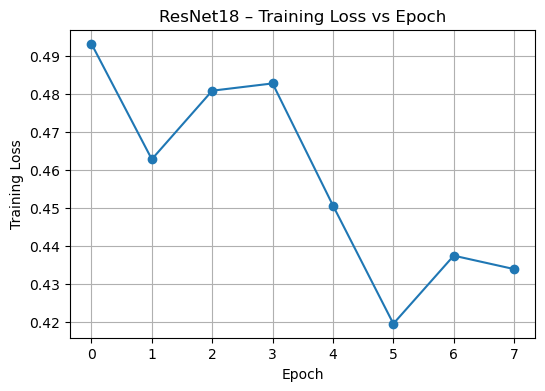

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("ResNet18 – Training Loss vs Epoch")
plt.grid(True)
plt.show()

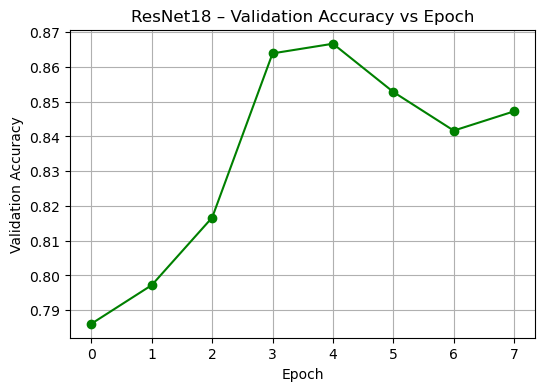

In [21]:
plt.figure(figsize=(6,4))
plt.plot(val_accuracies, marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("ResNet18 – Validation Accuracy vs Epoch")
plt.grid(True)
plt.show()

In [22]:
model.eval()
import torch
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        

In [23]:
num_classes = len(train_dataset.classes)
cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)

for t, p in zip(all_labels, all_preds):
    cm[t, p] += 1

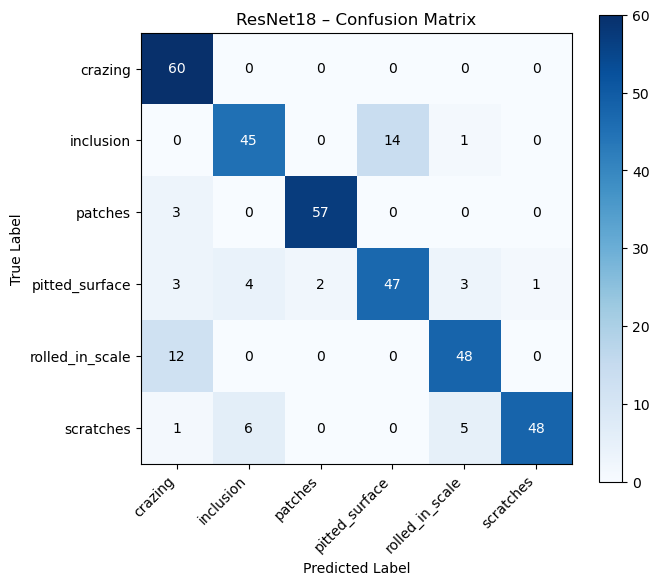

In [24]:
class_names = train_dataset.classes

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ResNet18 – Confusion Matrix")

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j].item(),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()